# Simulation of QAOA circuits with depolarizing noise

----
## Gian Giacomo Guerreschi, Intel Labs
----

Auxiliary material presented at the workshop on **Advanced Simulations of Quantum Computations**:  
https://events.cels.anl.gov/event/167/overview

Virtual event, 2021/10/17-18

# Intel Quantum Simulator (IQS)
----

IQS is a massively parallel simulator of quantum circuits.
* An $n$-qubit state is represented as a complex vector of $2^n$ components. The memory requirement therefore grows exponentially.
* One can consider using multiple computing processors, each storing part of the state. Communication between processors is required to simulate certain quantum gates. 
* When $2^p$ processors are used, each stores $2^m$ complex amplitudes ($m=n-p$).

<img src="iqs-distributed-state.png" width="800">

Implementation of 1-qubit gates.

* If gates act on qubit $k$, the pair of amplitudes involved in the transformation are distance $2^k$ apart.
* Internal loop updates $2^k$ of these amplitude pairs.
* The outer loop has a stride of $2\times2^k$, corresponding to all amplitudes involved in the inner loop.

<table><tr>
<td> <img src="iqs-1-qubit-gate-pseudocode.png" height="800"/> </td>
</tr></table>

2-qubit gates are more complicated since one has to consider multiple possibility for the communication pattern.

IQS provides methods to:

* Initialize the qubit register in any computational basis state or in a random state.
* Implement arbitrary 1-qubit gates. In addition, the most commonly-used gates are explicitly provided: Hadamard, Paulis, rotations, ...
* Implement any controlled 1-qubit gate (involving a total of 2 qubits). In addition, the most commonly-used gates are explicitly provided: Controlled-X, Controlled-Z, ...
* Get the probability of measuring any qubit in the computational basis.
* Get the expectation value of any product of Pauli operators.

Advanced methods include:

* Inclusion of noise via quantum channels, for example to simulate decoherence and dissipation.
* Parallel simulation of many states, possibly with individual modifications to the quantum circuit.
* Extra features to facilitate simulation of QAOA circuits.

# Quantum Approximate Optimization Algorithm (QAOA)
----

* Discussion of a specific combinatorial problem: MaxCut.
* Practical introduction to Intel Quantum Simulator: simulating QAOA circuits.
* Visualize effect of noise.

### Import required libraries

* Intel Quantum Simulator [binding of the C++ implementation]
* numpy [standard numerical library for Python]
* networkx [to create and visualize graphs]
* matplotlib [to visualize the results]
* scipy [to optimize the QAOA circuits]
* pandas [to store results in dataframes]

In [1]:
import sys
sys.path.insert(0, '../../build/lib')
import intelqs_py as iqs
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

file_df1 = 'study_TYPE-channel_qQUBITS.pkl'

# Initialize MPI environment (only once)
is_mpi_env_initialized = False
try: myrank
except NameError:
    iqs.EnvInit()
    myrank = iqs.MPIEnvironment.GetRank()
    is_mpi_env_initialized = True

# MaxCut problem
----

* It is a graph bipartition problem.
* It is a NP-complete problem.
* It has already been mentioned in a few talks in this workshop.
* Examples: ring and random graphs (Erdos, k-regular graphs, NM, ...).

<img src="Max-cut.svg.png" height="800"/>

How to compute the value of the cut?  
Consider that we label the colors as "+1" and "-1".
In analogy with spins, let us use the variable $s_i$ for the color of the $i$-th node.
Each term of the function returning the cut value can be written as:
$$f(s_i,s_j) = 1-\delta_{s_i, \, s_j} = \frac{1 - s_i \, s_j}{2}$$

### Generate the Max-Cut instance (random 3-regular graph)

There are 10 nodes:  [0, 1, 2, 4, 7, 6, 8, 5, 9, 3]
There are 15 edges:  [(0, 1), (0, 6), (0, 2), (1, 3), (1, 9), (2, 4), (2, 7), (4, 6), (4, 5), (7, 5), (7, 8), (6, 8), (8, 9), (5, 3), (9, 3)]

The max value of the cut is : 13


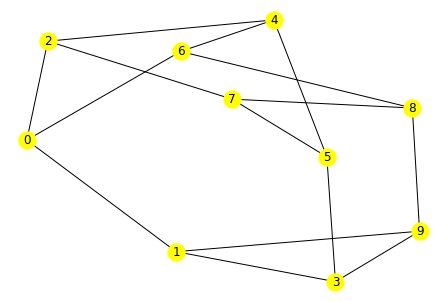

In [2]:
# Create a 3-regular graph:
num_qubits = 10
G = nx.random_regular_graph(3, num_qubits, seed=1234)
adjacency_matrix = nx.to_numpy_array(G, dtype=int)

# Allocate memory for the diagonal of the objective function.
cut_values = iqs.QubitRegister(num_qubits, 'base', 0, 0)
max_cut_value = iqs.InitializeVectorAsMaxCutCostFunction(cut_values, adjacency_matrix.flatten().tolist())

print('There are', G.number_of_nodes(), 'nodes: ', list(G.nodes))
print('There are', G.number_of_edges(), 'edges: ', list(G.edges))
print("\nThe max value of the cut is : {0:2d}".format(max_cut_value), flush=True)

nx.draw(G, node_color='yellow', with_labels=True)
plt.show()

# Simulation of QAOA circuits
----

The Quantum Approximate Optimization Algorithm (QAOA) is a variational algorithm to solve combinatorial problems.
Here we provide the syntax to quickly define and simulate QAOA circuits.

### Define the QAOA circuit
----

- prepare the reference state $|+++...+\rangle$
- iterate throught the QAOA steps
- each step is composed by $\exp(-i C \gamma)$, with $C$ being the cost function, and the transverse field mixing

----
**NOTE:** Discuss ***emulation vs simulation*** and how the global operation defined by the cost function can be implemented in either case.

In [4]:
def cut_value_from_qaoa_circuit(parameters, state, cut_values, noise_chi_matrix=None, ensemble_size=1):
    num_qubits=state.NumQubits()
    state.Initialize("++++",0)
    assert len(parameters)%2==0
    qaoa_depth = int(len(parameters)/2)
    for p in range(qaoa_depth):
        gamma = parameters[2*p]
        beta = parameters[2*p+1]
        # exp(-i gamma C)
        iqs.ImplementQaoaLayerBasedOnCostFunction(state, cut_values, gamma)
        # exp(-i beta  B)
        for qubit in range(num_qubits):
            state.ApplyRotationX(qubit, beta)
    # At this point |psi> corresponds to the state at the end of the QAOA circuit.
    cut_average = iqs.GetExpectationValueFromCostFunction(state, cut_values)
    return cut_average;

### Run circuit with random parameters and visualize results

Random choice of QAOA parameters.
QAOA circuit with random parameter values (p=3).
Average cut value = 6.300353004976739


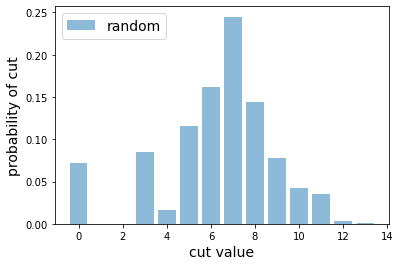

The probabilities of the cut values are:
 cut =     0       1       2       3       4       5       6       7       8       9      10      11      12      13
prob =  0.0723  0.0000  0.0000  0.0849  0.0157  0.1161  0.1624  0.2449  0.1446  0.0780  0.0419  0.0356  0.0030  0.0007


In [6]:
# Define quantum state
psi = iqs.QubitRegister(num_qubits, "++++", 0, 0)
# Reference state
histo_ref = iqs.GetHistogramFromCostFunction(psi, cut_values, max_cut_value)

# Choose parameters at random, each in [0, pi)
np.random.seed(7777)
qaoa_depth = 3
gamma = np.random.random_sample((2*qaoa_depth,))*np.pi
print("Random choice of QAOA parameters.")

# Compute cut value (expectation value at the end of QAOA circuit)
cut = cut_value_from_qaoa_circuit(gamma, state=psi, cut_values=cut_values)
print('QAOA circuit with random parameter values (p={}).\nAverage cut value = {}'.format(qaoa_depth,cut))
histo_rand = iqs.GetHistogramFromCostFunction(psi, cut_values, max_cut_value)

# Plot histogram.
x = np.arange(max_cut_value+1)
fig = plt.bar(x, histo_rand, align='center', alpha=0.5, label='random')
if False:
    fig = plt.bar(x, histo_ref, align='center', alpha=0.5, label='|++++>')
plt.xlabel('cut value', fontsize=14)
plt.ylabel('probability of cut', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.show()

print("The probabilities of the cut values are:")
print(" cut = ", "    ".join(["{0:4d}".format(c) for c in range(max_cut_value+1)]))
print("prob = ", "  ".join(["{0:1.4f}".format(p) for p in histo_rand]))

### Optimization of QAOA circuit

We have already defined a function that, given the parameters' values, returns the expectation value of the cut function.

We can use standard optimization tools from SciPy to improve the QAOA parameters.

In [9]:
def cost_function(parameters, state, cut_values):
    return -cut_value_from_qaoa_circuit(parameters, state, cut_values)

res = minimize(cost_function, gamma, args=(psi, cut_values), method='cobyla')
gamma_opt = res.x
print(res)

     fun: -11.497191318593153
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 661
  status: 1
 success: True
       x: array([3.54120196, 1.93513351, 1.11665729, 3.85188649, 2.85608135,
       1.33300078])


Average cut value =  -11.497191318593153


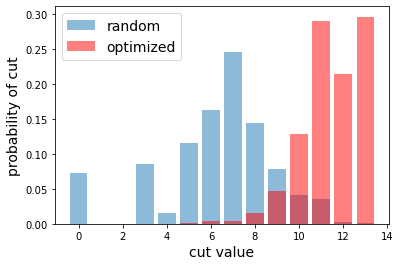

In [11]:
cut = cut_value_from_qaoa_circuit(gamma_opt, psi, cut_values)
print("Average cut value = ", -cut)
histo_opt = iqs.GetHistogramFromCostFunction(psi, cut_values, max_cut_value)

# Plot histogram.
x = np.arange(max_cut_value+1)
fig = plt.bar(x, histo_rand, align='center', alpha=0.5, label='random')
fig = plt.bar(x, histo_opt, align='center', alpha=0.5, color='red', label='optimized')
plt.xlabel('cut value', fontsize=14)
plt.ylabel('probability of cut', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.show()

# Simulation with noise
----

## Simulate repetead applications of the same channel

For all channels, the initial state is $|-\rangle_3 |+\rangle_2 |1\rangle_1 |0\rangle_0$, with qubits ordered from right to left.

### Depolarizing channel

The input state $\rho$ is transformed to the output state $\rho^\prime$ according to: 
$$\rho^\prime = (1-p) \rho + \frac{p}{3} ( X.\rho.X + Y.\rho.Y + Z.\rho.Z )$$

Interpretation: nothing happens with probability $(1-p)$, otherwise each of the Pauli errors happens with equal probability $p/3$. Convergence towards the maximally mixed state happens with (single qubit) rate $\lambda=4 \frac{p}{3}$.


### Dephasing channel

The input state $\rho$ is transformed to the output state $\rho^\prime$ according to: 
$$\rho^\prime = (1-p) \rho + p Z.\rho.Z$$

Interpretation: nothing happens with probability $(1-p)$, otherwise the Pauli Z error happens with probability $p$.

### Amplitude-damping channel

The Kraus operators are $M_0=\begin{bmatrix} 1 & 0 \\ 0 & \sqrt{1-p}\end{bmatrix}$
and $M_1=\begin{bmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{bmatrix}$.

The decomposition in Pauli matrices leads to:
$M_0 = \frac{1+\sqrt{1-p}}{2} I + \frac{1-\sqrt{1-p}}{2} Z$ and 
$M_1 = \frac{\sqrt{p}}{2} (X  + i Y)$.

The result is:
$$\rho^\prime = M_0 \rho M_0^\dagger + M_1 \rho M_1^\dagger = \sum_{i,j} \chi_{i,j} \sigma_i \rho \sigma_j$$
with
$$\chi = \frac{1}{4} \begin{bmatrix} (1+\sqrt{1-p})^2 & 0 & 0 & p \\
                                    0 & p^2 & -i p^2 & 0 \\
                                    0 & i p^2 & p^2 & 0 \\
                                    p & 0 & 0 & (1-\sqrt{1-p})^2 \end{bmatrix}$$

In [12]:
channel_type = 'depolarizing'
#channel_type = 'dephasing'
#channel_type = 'amplitude-damping'

# Prapare the initial state
num_qubits = 4
index = 0*1 + 1*2 + 0*4 + 1*8
psi = iqs.QubitRegister(num_qubits, 'base', index, 0) # |psi> = |1010> = |1>_3 .|0>_2 .|1>_1 .|0>_0
psi.ApplyHadamard(2)                                  # |psi> = |1+10>
psi.ApplyHadamard(3)                                  # |psi> = |-+10>

# Associate a random-number-generator to the state
rng = iqs.RandomNumberGenerator();
rng_seed = 7777;
rng.SetSeedStreamPtrs( rng_seed );

# Define the chi-matrix
p=0.01
chi = iqs.CM4x4()
if channel_type == 'depolarizing':
    chi[0,0] = 1-p
    chi[1,1] = p/3
    chi[2,2] = p/3
    chi[3,3] = p/3
elif channel_type == 'dephasing':
    chi[0,0] = 1-p
    chi[3,3] = p
elif channel_type == 'amplitude-damping':
    chi[0,0] = (1+np.sqrt(1-p))**2 /4
    chi[0,3] = p/4
    chi[3,0] = p/4
    chi[3,3] = (1-np.sqrt(1-p))**2 /4
    chi[1,1] = p**2 /4
    chi[1,2] = -1j * p**2 /4
    chi[2,1] = +1j * p**2 /4
    chi[2,2] = p**2 /4
else:
    print('ERROR: unknown noise channel')
chi.SolveEigenSystem()
chi.Print(True)

# parameter of the evolution
num_ensemble_states = 500
num_time_steps = 200
collective_list = []
for s in range(num_ensemble_states):
    if s%100==0:
        print("-- state", s, "of the ensemble")
    psi_s = iqs.QubitRegister(psi)
    psi_s.SetRngPtr(rng);
    for t in range(0,num_time_steps):
        sq_overlap = np.absolute(psi_s.ComputeOverlap(psi))**2 # the overlap is computed as if at the begin of time step t
        assert sq_overlap<=1
        for q in range(num_qubits):
            psi_s.ApplyChannel(q, chi)
        collective_list.append([s, t, sq_overlap])
df = pd.DataFrame(collective_list, columns =['s', 't', 'sq_overlap'])
filename = file_df1.replace('TYPE', channel_type)
filename = filename.replace('QUBITS', str(num_qubits))
df.to_pickle(filename)
print('data saved in file ', filename)

-- state 0 of the ensemble
-- state 100 of the ensemble
-- state 200 of the ensemble
-- state 300 of the ensemble
-- state 400 of the ensemble
data saved in file  study_depolarizing-channel_q4.pkl


### Plot the results (one type of channel at a time)

Depolarizing:  
$|0\rangle\langle 0| \rightarrow I$  
$|1\rangle\langle 1| \rightarrow I$

Dephasing:  
$|0\rangle\langle 0| \rightarrow |0\rangle\langle 0|$  
$|1\rangle\langle 1| \rightarrow |1\rangle\langle 1|$

Amplitude-damping:  
$|0\rangle\langle 0| \rightarrow |0\rangle\langle 0|$  
$|1\rangle\langle 1| \rightarrow |0\rangle\langle 0|$


Initial state |-+10>.
Plot the squared overlap |<-+10|psi(t)>|^2


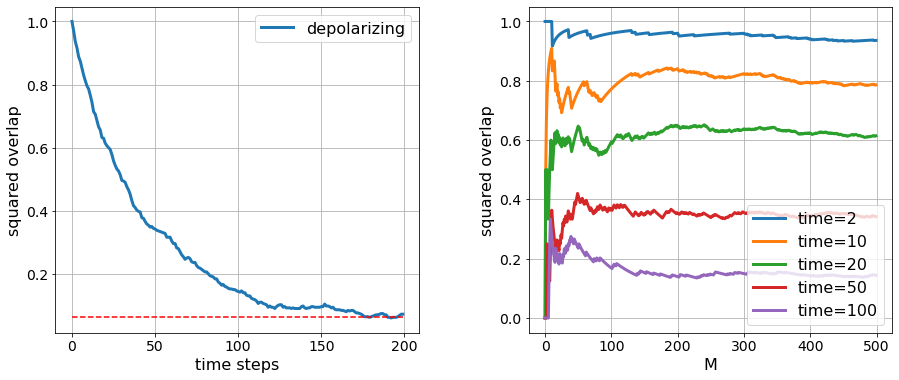

Figure saved as file  study_depolarizing-channel_q4_t200_s500.png


In [13]:
channel_type = 'depolarizing'
num_ensemble_states = 500
num_qubits = 4
filename = file_df1.replace('TYPE', channel_type)
filename = filename.replace('QUBITS', str(num_qubits))
df = pd.read_pickle(filename)
#print(df.head)

fig, axs = plt.subplots(1,2, sharex=False, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3)
axs[0].tick_params(axis='both', labelsize=14)
axs[1].tick_params(axis='both', labelsize=14)

dfs = df.groupby(['t'])['sq_overlap'].mean().reset_index()
axs[0].plot(dfs.t, dfs.sq_overlap, linewidth=3, label=channel_type)
if channel_type == 'depolarizing':
    axs[0].plot(dfs.t, [1/2**num_qubits]*len(dfs.t), 'r--')
elif channel_type == 'dephasing':
    axs[0].plot(dfs.t, [1/4]*len(dfs.t), 'r--')
elif channel_type == 'amplitude-damping':
    axs[0].plot(dfs.t, [0]*len(dfs.t), 'r--')

# Fix time step, compute the convergence when average is over more ensemble states.
for t in [2, 10, 20, 50, 100]:
    # If we do not take a copy, pandas would complain that:
    # 'A value is trying to be set on a copy of a slice from a DataFrame.'
    dft = df.loc[(df['t'] == t)].copy()
    a = dft['sq_overlap'].to_numpy()
    a = np.cumsum(a)
    b = np.ones(num_ensemble_states)
    b = np.cumsum(b)
    c = np.divide(a, b)
    dft['avg_sq_overlap'] = c
    axs[1].plot(dft.s, dft.avg_sq_overlap, linewidth=3, label='time={}'.format(t))

axs[0].set_ylabel('squared overlap', fontsize=16)
axs[0].set_xlabel('time steps', fontsize=16)
axs[0].grid()
axs[0].legend(loc='upper right', fontsize=16)
axs[1].set_xlabel('num states in the average', fontsize=16)
axs[1].set_xlabel('M', fontsize=16)
axs[1].set_ylabel('squared overlap', fontsize=16)
axs[1].legend(loc='lower right', fontsize=16)
axs[1].grid()

filename = 'study_{}-channel_q{}_t{}_s{}.png'.format(
    channel_type, num_qubits, num_time_steps, num_ensemble_states)
fig.savefig(filename)
print('\nInitial state |-+10>.\nPlot the squared overlap |<-+10|psi(t)>|^2')
plt.show()
print('Figure saved as file ', filename)

----
## END
----

In [14]:
 # Finalize MPI environment
if is_mpi_env_initialized:
    iqs.EnvFinalize()
    is_mpi_env_initialized = False